## Fig S18: Effects of extrinsic noise on information footprints with weak repressor binding

Required packages:

In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

fdir = '../data/'
out_fdir = '../plots/figS18/'

### 0. Loading input data

Same as in the notebook `fig3_architecture.ipynb`, we first load the required promoter sequence and energy matrices.

In [2]:
_genome = []
for record in SeqIO.parse(fdir + "mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv(fdir + 'ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

We manually specify the binding site sequences. Note that these sequences all need to be contained within the promoter sequence itself.

In [3]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = 'AATTGTGAGCGGATAACAATT'

We read in the known energy matrix for RNA polymerase. This energy matrix is experimentally determined and shown in Figure 2 of Brewster et al., 2012. (https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002). We use the function `fix_wt` from the `tregs` package to normalize the energy matrix such that the wild type base identities correspond to a binding energy of $0\ k_BT$.

In [4]:
rnap_emat_raw = np.loadtxt(fdir + 'energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

Similarly, we read in the experimentally determined energy matrix for the lacI repressor (Barnes et al., 2019) and normalize the energy matrix.

In [5]:
O1_1027_raw = np.load(fdir + 'energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### 1. Changing repressor binding energy

In order to simulate extrinsic noise, we define two functions `get_parameters` and `simrep_pbound_with_noise`. `simrep_pbound_with_noise` defines the expression for probability of RNAP being bound when the copy number of RNAP and repressors are drawn from a Log-Normal distribution. `get_paramters` is a helper function that allows us to convert the mean and coefficient of variation of the Log-Normal distribution to `mu` and `sigma` used by the `rng.lognormal` function.

In [6]:
def get_parameters(mean, cov):
	"""
    Calculate parameters for a Log-Normal distribution given the mean and coefficient of variation.

    Parameters:
    ----------
    mean : float
        Mean of the distribution.
    cov : float
        Coefficient of variation, defined as the standard deviation divided by the mean.

    Returns:
    -------
    mu : float
        The log-transformed mean (mu) parameter for the Log-Normal distribution.
    sigma : float
        The scale (sigma) parameter for the Log-Normal distribution.
    """
	mu = np.log(mean)
	alpha = np.sqrt(np.log(cov**2 + 1)) / np.log(mean)
	sigma = alpha * np.log(mean)
	return mu, sigma

def simrep_pbound_with_noise(p_seq, r_seq, n_NS,
							 p_emat, r_emat, ep_wt, er_wt,
							 mean_p, mean_r, cov):
	
    """
    Simulate the probability of RNAP being bound in the presence of noise, modeled by log-normal distributions.

    Parameters
    ----------
    p_seq : str
        Sequence of the RNAP binding site.
    r_seq : str
        Sequence of the repressor binding site.
    n_NS : float
        Scaling factor for non-specific binding.
    p_emat : array-like
        Energy matrix for RNAP.
    r_emat : array-like
        Energy matrix for repressor.
    ep_wt : float
        Wild-type binding energy for RNAP.
    er_wt : float
        Wild-type binding energy for the repressor.
    mean_p : float
        Mean copy number of RNAP.
    mean_r : float
        Mean copy number of repressors.
    cov : float
        Coefficient of variation.

    Returns
    -------
    float
        The probability of RNAP being bound.
    """

    rng = np.random.default_rng()
	
    mu_p, sigma_p = get_parameters(mean_p, cov)
    mu_r, sigma_r = get_parameters(mean_r, cov)

    n_p = rng.lognormal(mu_p, sigma_p, 1)[0]
    n_r = rng.lognormal(mu_r, sigma_r, 1)[0]
	
    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_r = tregs.simulate.get_weight(r_seq, r_emat, e_wt=er_wt)

    z = np.zeros(3)
    z[0] = 1
    z[1] = n_p / n_NS * w_p
    z[2] = n_r / n_NS * w_r

    return z[1] / np.sum(z)

First we simulate a footprint where the repressor binds weakly at its binding site.

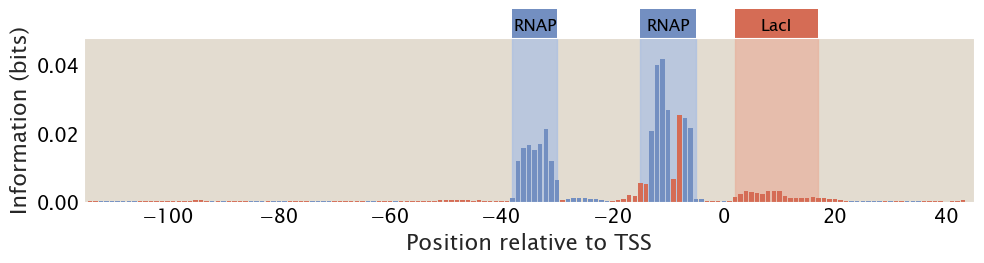

In [7]:
n_NS = len(genome)
n_p = 5000
n_r = 100
ep_wt = -5
er_wt = -11

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               outfile=out_fdir + 'extrinsic_noise_low_signal_fp1.pdf')

Next we add extrinsic noise to a footprint with weak repressor binding.

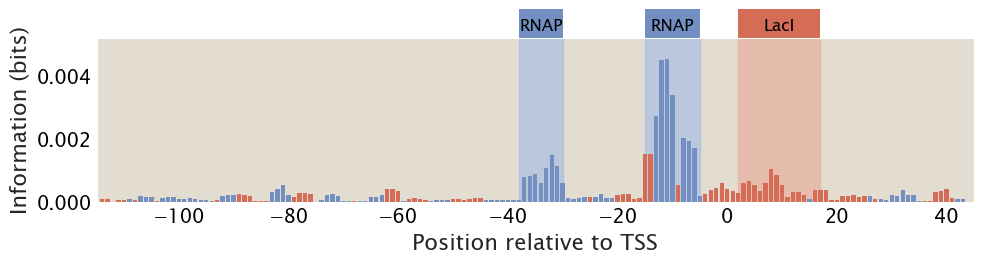

In [8]:
n_NS = len(genome)
ep_wt = -5
er_wt = -11

mean_p = 5000
mean_r = 100
cov = 100

df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
						*[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
						  mean_p, mean_r, cov])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               outfile=out_fdir + 'extrinsic_noise_low_signal_fp2.pdf')